# Stacked Denoising AutoEncoder

1. Input Layer : Energy, Contrast, Entropy, Homogeneity, SumAverage, Dissimilarity, AutoCorrelation, Skewness, Kurtosis, Average HU Value
2. Feature 1 : 7
3. Feature 2 : 3
4. Softmax : 2
5. Learning rate : .1 ~ .01
6. Noise factor : 10% on input vector
7. Activation function : sigmoid
8. Cost function : negative log-likelihood

## Three models
1. Feature Extraction : Input -> HL1 -> HL2 -> Decoder -> Weight update
2. Predict Features : Input -> HL1 -> HL2 -> Output
3. Classification : Input of 3 -> HL1 -> HL2 -> Classifier -> Output

In [69]:
import numpy as np
import pandas as pd
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers, regularizers
from keras.callbacks import TensorBoard
from keras.utils import to_categorical

# Function for cross validation
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [18]:
# Preparing dataset - total 26909 images : 14294 nodules + 12745 non-nodules
df = pd.read_csv('./Datas/nodules_all_190625.csv', index_col=0)
# select seed to randomize - [0, 3136, 8405, 4242, 5293]
np.random.seed(0)
print(df.shape, '\nDataset loading complete')

(26910, 11) 
Dataset loading complete


In [19]:
# Slice the inputs and labels
# iloc : use integer index for slice
# loc : use label for slice
cols = df.shape[1] - 1
x_train = df.iloc[:, :cols] 
y_train = df.iloc[:, cols]
y_labels_train = to_categorical(y_train)

# add noise to the input data
noise_factor = 0.1
x_train_noisy = x_train * (1 + noise_factor *\
            np.random.binomial(n=1, p=0.1, size=x_train.shape) )
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

In [65]:
## Build Autoencoder
# Input placeholder
input_data = Input(shape=(cols,))

# Hidden Layer 1
hidden_1 = Dense(6, activation='relu', kernel_initializer='he_normal',
                    )(input_data)

# Hidden Layer 2
hidden_2 = Dense(4, activation='relu', kernel_initializer='he_normal',
                    )(hidden_1)

# Decoded Layer 1
decoded_1 = Dense(6, activation='sigmoid', kernel_initializer='he_normal')(hidden_2)

# Decoded Layer 2 (reconstructed data)
decoded_2 = Dense(cols, activation='sigmoid', kernel_initializer='he_normal')(decoded_1)

In [66]:
# this model maps an input to its reconstruction
from keras import optimizers

autoencoder_recon = Model(input_data, decoded_2)
ada = optimizers.Adadelta(decay=0.2)
autoencoder_recon.compile(optimizer=ada, loss='binary_crossentropy')
autoencoder_recon.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 6)                 66        
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_29 (Dense)             (None, 6)                 30        
_________________________________________________________________
dense_30 (Dense)             (None, 10)                70        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


In [67]:
autoencoder_recon.fit(x_train_noisy, x_train,
                      epochs=100, batch_size=256,
                      validation_split=0.05,
                      verbose=1,
                      shuffle=True,
                      # callbacks=[TensorBoard(log_dir='./logs/autoencoder_190601-5')]
                     )

Train on 25564 samples, validate on 1346 samples
Epoch 1/100
25564/25564 [==============================] - 1s 31us/step - loss: 0.6999 - val_loss: 0.7026
Epoch 2/100
25564/25564 [==============================] - 0s 10us/step - loss: 0.6839 - val_loss: 0.6936
Epoch 3/100
25564/25564 [==============================] - 0s 10us/step - loss: 0.6769 - val_loss: 0.6880
Epoch 4/100
25564/25564 [==============================] - 0s 10us/step - loss: 0.6721 - val_loss: 0.6837
Epoch 5/100
25564/25564 [==============================] - 0s 10us/step - loss: 0.6683 - val_loss: 0.6803
Epoch 6/100
25564/25564 [==============================] - 0s 10us/step - loss: 0.6652 - val_loss: 0.6774
Epoch 7/100
25564/25564 [==============================] - 0s 10us/step - loss: 0.6625 - val_loss: 0.6748
Epoch 8/100
25564/25564 [==============================] - 0s 10us/step - loss: 0.6601 - val_loss: 0.6725
Epoch 9/100
25564/25564 [==============================] - 0s 10us/step - loss: 0.6579 - val_loss: 0.67

In [73]:
from keras import Sequential

# Encoder
autoencoder_encoder = Model(input_data, hidden_2)

def create_model(): 
    # create model 
    model = Sequential() 
    model.add(Dense(2, activation='softmax')) 
    # Compile model 
    model.compile(optimizer='adadelta', loss='categorical_crossentropy',
                            metrics=['accuracy'])
    return model

x_feature = autoencoder_encoder.predict(x_train)

# Cross Validation

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=256)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
result = cross_validate(model, x_feature, y_train, 
                        scoring=['accuracy','precision','recall','f1','roc_auc'], 
                        cv=kfold)

Epoch 1/50
21528/21528 [==============================] - 1s 28us/step - loss: 0.7913 - acc: 0.4694
Epoch 2/50
21528/21528 [==============================] - 0s 7us/step - loss: 0.7198 - acc: 0.4479
Epoch 3/50
21528/21528 [==============================] - 0s 7us/step - loss: 0.6998 - acc: 0.4733
Epoch 4/50
21528/21528 [==============================] - 0s 6us/step - loss: 0.6958 - acc: 0.5218
Epoch 5/50
21528/21528 [==============================] - 0s 6us/step - loss: 0.6945 - acc: 0.5314
Epoch 6/50
21528/21528 [==============================] - 0s 6us/step - loss: 0.6934 - acc: 0.5336
Epoch 7/50
21528/21528 [==============================] - 0s 6us/step - loss: 0.6924 - acc: 0.5354
Epoch 8/50
21528/21528 [==============================] - 0s 7us/step - loss: 0.6913 - acc: 0.5372
Epoch 9/50
21528/21528 [==============================] - 0s 6us/step - loss: 0.6903 - acc: 0.5394
Epoch 10/50
21528/21528 [==============================] - 0s 7us/step - loss: 0.6894 - acc: 0.5412
Epoch 11

21528/21528 [==============================] - 0s 7us/step - loss: 0.6807 - acc: 0.5639
Epoch 34/50
21528/21528 [==============================] - 0s 7us/step - loss: 0.6807 - acc: 0.5631
Epoch 35/50
21528/21528 [==============================] - 0s 7us/step - loss: 0.6807 - acc: 0.5627
Epoch 36/50
21528/21528 [==============================] - 0s 6us/step - loss: 0.6807 - acc: 0.5634
Epoch 37/50
21528/21528 [==============================] - 0s 7us/step - loss: 0.6807 - acc: 0.5633
Epoch 38/50
21528/21528 [==============================] - 0s 7us/step - loss: 0.6807 - acc: 0.5638
Epoch 39/50
21528/21528 [==============================] - 0s 6us/step - loss: 0.6807 - acc: 0.5624
Epoch 40/50
21528/21528 [==============================] - 0s 6us/step - loss: 0.6808 - acc: 0.5632
Epoch 41/50
21528/21528 [==============================] - 0s 7us/step - loss: 0.6807 - acc: 0.5632
Epoch 42/50
21528/21528 [==============================] - 0s 7us/step - loss: 0.6807 - acc: 0.5630
Epoch 43/50


21528/21528 [==============================] - 0s 7us/step - loss: 0.6812 - acc: 0.5644
Epoch 48/50
21528/21528 [==============================] - 0s 7us/step - loss: 0.6812 - acc: 0.5659
Epoch 49/50
21528/21528 [==============================] - 0s 7us/step - loss: 0.6812 - acc: 0.5647
Epoch 50/50
21528/21528 [==============================] - 0s 7us/step - loss: 0.6811 - acc: 0.5662


## Evaluation Metrics

### 3. Sensitivity(True positive rate, TPR) or Recall
$$ TPR=\frac{TP}{TP+FN} $$

### 4. Precision(Positive predictive value, PPV)
$$ PPV=\frac{TP}{TP+FP} $$

In [84]:
print(result['test_accuracy'], 'Accuracy Average : ', result['test_accuracy'].mean())
print(result['test_precision'])
print(result['test_recall'])
print(result['test_f1'])
print(result['test_roc_auc'])

[0.56633222 0.55964326 0.56373096 0.56280193 0.56001486]
[0.56653895 0.56770978 0.57066667 0.57028224 0.56094959]
[0.77688266 0.71703393 0.74357192 0.72037749 0.74442478]
[0.65524372 0.63369397 0.64574532 0.63660232 0.63979312]
[0.57400509 0.56945046 0.5607862  0.56740222 0.57454387]


In [41]:
# 1. Accuracy
print(result, '\n Average Accuracy : ', np.average(result))

[0.75176514 0.7335563  0.75306577 0.74396135 0.737644  ] 
 Average Accuracy :  0.743998513563731


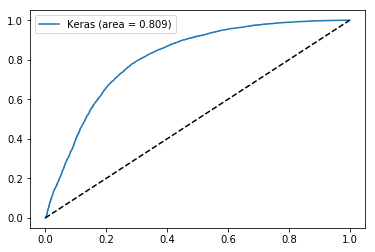

In [55]:
# 2. Area under the ROC-curve (AUC)
predicted = autoencoder_classify.predict(x_train)
prediction_result = np.argmax(predicted, axis=1)

from sklearn.metrics import roc_curve, auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train.values, predicted[:, 1])

import matplotlib.pyplot as plt
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

In [60]:
from sklearn.metrics import confusion_matrix
TN, FP, FN, TP = confusion_matrix(y_train.values, prediction_result).ravel()

In [61]:
sensitivity = TP/(TP+FN)
print('Sensitivity : ', sensitivity)

Sensitivity :  0.8550917495447542


In [62]:
precision = TP/(TP+FP)
print('Precision : ', precision)

Precision :  0.717880872581878


### 5.F-score 
$$ \text{F-score} = \frac{(PPV \times TPR)}{PPV+TPR} $$

In [63]:
f_score = (precision * sensitivity) / (precision + sensitivity)
print('F-score : ', f_score)

F-score :  0.39025091897075276


In [47]:
print(autoencoder_classify.layers)

[<keras.engine.input_layer.InputLayer object at 0x7fce94187be0>, <keras.layers.core.Dense object at 0x7fce94187c18>, <keras.layers.core.Dense object at 0x7fce94187898>, <keras.layers.core.Dense object at 0x7fce82fa0198>]


In [64]:
autoencoder_recon.layers[1].get_weights()

[array([[-0.7841006 , -0.16355142,  0.18469211,  0.6826534 ,  0.00487594,
          0.4217957 ],
        [ 0.5924229 , -0.9958263 , -0.6090429 , -0.41142   ,  0.01197936,
          0.05727339],
        [-0.94028544, -1.1634619 ,  0.34137434,  0.70762104,  0.13987039,
          0.25145087],
        [ 0.7924696 ,  1.333561  , -0.20176318, -0.69159657,  0.35309303,
          0.1907133 ],
        [ 0.6978187 ,  1.5954238 , -0.44775763,  0.7370469 ,  0.5436904 ,
         -0.32714024],
        [ 0.28056598,  0.02408662, -2.0073957 , -0.14676699,  0.7825968 ,
          1.1501373 ],
        [ 0.62142736, -0.82506585, -1.1632524 , -0.6304717 , -0.04658609,
          0.9203306 ],
        [ 0.1352186 , -0.01743425,  0.36319813, -1.0416112 ,  0.64138067,
         -0.67217976],
        [ 0.38327336, -0.14677049, -0.31413424, -0.2055226 , -0.80755603,
         -0.45608917],
        [-0.6541372 , -0.8415009 , -0.16127379, -1.2220824 ,  0.9243925 ,
          1.5886974 ]], dtype=float32),
 array([-0.20

In [ ]:
autoencoder_classify.layers[-1].get_weights()

Text(0.5,1,'Weights Colormap - 1')

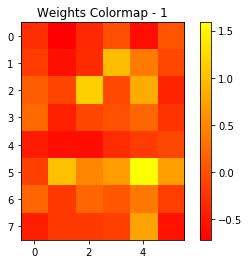

In [50]:
import matplotlib.pyplot as plt
weight, bias = autoencoder_recon.layers[1].get_weights()

plt.imshow(weight, cmap=plt.cm.autumn)
plt.colorbar()
plt.title('Weights Colormap - 1')

([<matplotlib.axis.XTick at 0x7fce8033b198>,
 <a list of 8 Text xticklabel objects>)

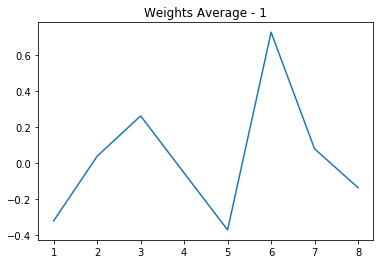

In [52]:
weight_avg = np.average(weight, axis=1)
plt.plot(range(1,9), weight_avg)
plt.title('Weights Average - 1')
plt.xticks(range(1,9))

In [ ]:
df_weight = pd.DataFrame(weight, 
                         columns=['Feature 1','Feature 2','Feature 3', 'Feature 4',
                                 'Feature 5','Feature 6', 'Feature 7'])

df_weight.to_csv("./Weights_sigmoid_1.csv")

In [40]:
decoded_all = autoencoder_recon.predict(x_train)
print(decoded_all)
print(x_train)

[[0.08309639 0.2017416  0.53755784 ... 0.26892006 0.13284165 0.7969153 ]
 [0.089535   0.2132976  0.7834557  ... 0.12539375 0.05533299 0.41297263]
 [0.12417826 0.26960486 0.73942655 ... 0.1593855  0.07446209 0.4347534 ]
 ...
 [0.40076244 0.58103806 0.53181195 ... 0.35224992 0.2124205  0.46843272]
 [0.2481029  0.45457193 0.44092247 ... 0.34503597 0.19681504 0.62167406]
 [0.4122715  0.61372685 0.33915403 ... 0.44327825 0.2911452  0.5968534 ]]
      Contrast  Dissimilarity   Entropy  SumAverage  AutoCorrelation  \
0     0.060793       0.191241  0.508526    0.835470         0.747732   
1     0.078852       0.185523  0.771363    0.424021         0.387763   
2     0.166583       0.338598  0.671784    0.514270         0.369265   
3     0.134599       0.289457  0.800151    0.421111         0.314318   
4     0.163204       0.316215  0.858170    0.362923         0.275476   
5     0.159482       0.294970  0.833486    0.319728         0.263842   
6     0.142493       0.271786  0.835539    0.320574 